#Install

In [1]:
!pip install gym==0.25.2

In [2]:
!pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 9.4 MB/s eta 0:00:00


In [ ]:
!pip install gym[box2d]

#Import

In [12]:
import gym
import torch

from collections import deque
import random

import copy
from torch.autograd import Variable
import numpy as np
import time
import json
import os
from datetime import datetime
import psutil
import os
import matplotlib.pyplot as plt

#Env

In [5]:
# Get current process ID
pid = os.getpid()
process = psutil.Process(pid)
env = gym.envs.make("LunarLander-v2")

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


#Model

In [8]:
class DQN():
    def __init__(self, n_state, n_action, n_hidden=50, lr=0.05):
        self.criterion = torch.nn.MSELoss()
        self.model = torch.nn.Sequential(
                        torch.nn.Linear(n_state, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_hidden),
                        torch.nn.ReLU(),
                        torch.nn.Linear(n_hidden, n_action)
                )


        self.model_target = copy.deepcopy(self.model)

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr)

    def update(self, s, y):
        """
        Update the weights of the DQN given a training sample
        @param s: state
        @param y: target value
        """
        s = np.array(s)
        y_pred = self.model(torch.Tensor(s))

        loss = self.criterion(y_pred, Variable(torch.Tensor(np.array(y))))
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()


    def predict(self, s):
        """
        Compute the Q values of the state for all actions using the learning model
        @param s: input state
        @return: Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model(torch.Tensor(np.array(s)))

    def target_predict(self, s):
        """
        Compute the Q values of the state for all actions using the target network
        @param s: input state
        @return: targeted Q values of the state for all actions
        """
        with torch.no_grad():
            return self.model_target(torch.Tensor(np.array(s)))

    def replay(self, memory, replay_size, gamma):
        """
        Experience replay with target network
        @param memory: a list of experience
        @param replay_size: the number of samples we use to update the model each time
        @param gamma: the discount factor
        """
        if len(memory) >= replay_size:
            replay_data = random.sample(memory, replay_size)

            states = []
            td_targets = []
            for state, action, next_state, reward, is_done in replay_data:
                states.append(state)
                q_values = self.predict(state).tolist()
                if is_done:
                    q_values[action] = reward
                else:
                    q_values_next = self.target_predict(next_state).detach()

                    q_values[action] = reward + gamma * torch.max(q_values_next).item()

                td_targets.append(q_values)

            self.update(states, td_targets)

    def copy_target(self):
        self.model_target.load_state_dict(self.model.state_dict())

    def name(self):
      return "Model C"



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#Epsilon function

In [7]:
def gen_epsilon_greedy_policy(estimator, epsilon, n_action):
    def policy_function(state):
        if random.random() < epsilon:
            return random.randint(0, n_action - 1)
        else:
            q_values = estimator.predict(state)
            return torch.argmax(q_values).item()
    return policy_function

#Parameters and hyperparameters

In [21]:

n_episode = 1000
replay_size = 142
n_state = env.observation_space.shape[0]
n_action = env.action_space.n
n_hidden = 62
target_update = 10
replay_size = 142
lr = 0.001
epsilon = 0.1
gamma = 1.0
dqn = DQN(n_state,n_action,n_hidden,lr)
memory = deque(maxlen=10000)
epsilon_decay = 0.99




#Train

Episode: 0 Reward: -313.86075422714646
Episode: 1 Reward: -403.76317739137306
Episode: 2 Reward: -146.77328790359255
Episode: 3 Reward: -170.362431413102
Episode: 4 Reward: -611.9888736916338
Episode: 5 Reward: -99.76339592916969
Episode: 6 Reward: -160.77657221511618
Episode: 7 Reward: -508.165816309715
Episode: 8 Reward: -595.8513184306161
Episode: 9 Reward: -108.58179129493843
Data appended to or written to JSON file successfully.
Average reward: -311.9887418806403


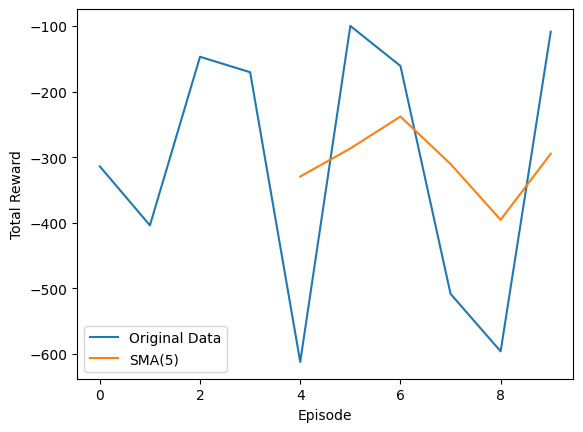

In [17]:
total_reward_episode = [0] * n_episode
for episode in range(n_episode):
    # print(f"Episode: {episode}")
    if episode % target_update == 0:
        dqn.copy_target()
    policy = gen_epsilon_greedy_policy(dqn,epsilon,n_action)
    state = env.reset()
    is_done = False

    while not is_done:
        # print(f"State: {state}")
        action = policy(state)
        next_state,reward,is_done,_ = env.step(action)
        total_reward_episode[episode] += reward
        memory.append((state,action,next_state,reward,is_done))

        if is_done:
            break

        dqn.replay(memory,replay_size,gamma)
        state = next_state
    print(f"Episode: {episode} Reward: {total_reward_episode[episode]}")
    epsilon = max(epsilon*epsilon_decay,0.01)

# Get the current date and time
current_datetime = str(datetime.now())

data = {"Time":current_datetime,
        "Data":{"Model":dqn.name(),
                "n_hidden":n_hidden,
                        "Target Update: ":target_update,
                        "Replay _size: ":replay_size,
                        "Learning rate: ":lr,
                        "Epsilon: ":epsilon,
                        "Gamma: ":gamma,
                        "Avg Reward":sum(total_reward_episode)/len(total_reward_episode)}
                        }
# Define the file path for your JSON file
file_path = 'data.json'

# Check if the JSON file exists
if os.path.exists(file_path):
    # Open the existing JSON file for appending
    with open(file_path, 'a') as file:
        # Append the dictionary as a new line in the file
        file.write('\n')
        json.dump(data, file, indent=4)
else:
    # Create a new JSON file and write the dictionary to it
    with open(file_path, 'w') as file:
        json.dump(data, file, indent=4)

print("Data appended to or written to JSON file successfully.")


print(f"Average reward: {sum(total_reward_episode)/len(total_reward_episode)}")





# Generate SMA(5) using numpy
sma_5 = np.convolve(total_reward_episode, np.ones(5)/5, mode='valid')

# Plot the original data
plt.plot(total_reward_episode, label='Original Data')

# Plot SMA(5)
plt.plot(np.arange(4,n_episode), sma_5, label='SMA(5)')

# Add labels and legend
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
figname = current_datetime+'.png'
plt.savefig(figname)
# plt.show()

In [20]:
# Get memory usage
mem_usage = process.memory_info().rss  # in bytes
print(f"Memory usage: {mem_usage / (1024 * 1024)} MB")  # Convert to MB for readability

Memory usage: 603.73046875 MB


#Save the model

In [18]:
model_path = current_datetime+".pth"

In [19]:
torch.save(dqn.model.state_dict(), model_path)